In [1]:
import os
import tensorflow as tf
import random
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Layer
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.metrics import log_loss
from sklearn.linear_model import LinearRegression
import fnmatch

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.linear_model import LogisticRegression

In [3]:
import cv2
import pandas as pd
from tensorflow.keras.layers import BatchNormalization
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials, anneal
import matplotlib.pyplot as plt
import statistics 

In [5]:
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.applications.xception import  Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import  ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
#from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.mobilenet import MobileNet
import tensorflow.keras.callbacks as kcallbacks
import tensorflow.keras
#from keras.preprocessing.image import load_img,img_to_array
import math
import random
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
seed=24
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [94]:
print("TensorFlow version:", tf.__version__)
#print("Keras version:", keras.__version__)

TensorFlow version: 2.8.0


In [6]:
target_img = (224,224)
input_img = (224,224,3)
batch = 32

train_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)
                                #    horizontal_flip=True,
                                #    zoom_range = 0.2,
                                #    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
        'Selected Features/Train_224x224/',
        target_size = target_img,
        batch_size = batch,
        class_mode = 'binary')
validation_generator = valid_datagen.flow_from_directory(
        'Selected Features/Test_224x224/',
        target_size = target_img,
        batch_size = batch,
        class_mode = 'binary')

Found 1498 images belonging to 2 classes.
Found 703 images belonging to 2 classes.


In [7]:
label = {v: k for k, v in validation_generator.class_indices.items()}
print(label)

{0: '0', 1: '1'}


In [8]:
directory = './Selected Features/Test_224x224/'

test_images = []

for subdir, _, files in os.walk(directory):
    for file in files:
        if fnmatch.fnmatch(file, '*.png'):
            test_images.append(os.path.join(subdir, file))

test_labels = [os.path.basename(os.path.dirname(image_path)) for image_path in test_images]

print(test_labels[0], test_images[0])

1 ./Selected Features/Test_224x224/1/357.png


In [9]:
y_test = np.array(test_labels).astype(int)
print(y_test.shape)

(703,)


In [10]:
#Test Images 
length = len(test_images)
batch_size = length  # Set the batch size equal to the number of images

# Create an empty array to store the images
images = np.empty((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(length):
    test = cv2.imread(test_images[i])
    test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    img = np.array(test) / 255.0
    
    # Assign the image to the corresponding index in the images array
    images[i] = img

In [11]:
images.shape

(703, 224, 224, 3)

In [12]:
output_unit = 1

In [13]:
def Prediction(vgg_model):
#read images from validation folder
    directory = './Selected Features/Test_224x224/'

    image_files = []

    for subdir, _, files in os.walk(directory):
        for file in files:
            if fnmatch.fnmatch(file, '*.png'):
                image_files.append(os.path.join(subdir, file))

    test_labels = [os.path.basename(os.path.dirname(image_path)) for image_path in image_files]
            
    y_test = np.array(test_labels).astype(int)

    #predict=[]
    #length=len(test_images)
    label=validation_generator.class_indices
    label={v: k for k, v in label.items()}
    
    length = len(test_images)
    batch_size = length  # Set the batch size equal to the number of images

    # Create an empty array to store the images
    images = np.empty((batch_size, 224, 224, 3), dtype=np.float32)

    for i in range(length):
        test = cv2.imread(test_images[i])
        test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
        img = np.array(test) / 255.

        # Assign the image to the corresponding index in the images array
        images[i] = img
    
    preds = vgg_model.predict(images)
    prediction = (preds > 0.5).astype(int)
    accuracy1 = accuracy_score(y_test, prediction)
    print(accuracy1)
    
    return accuracy1

# Tree Parzen Estimator (Bayesian Optimization)

In [14]:
def Prediction_Model(output_unit, frozen, unit, epochs,patience, lr, dropout_rate, verbose=2, path='./VGG16_tpe_selected_features.h5',input_shape=input_img):
    
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    for layer in base_model.layers[:frozen]:
        layer.trainable = False
    for layer in base_model.layers[frozen:]:
        layer.trainable = True

    model = Flatten()(base_model.output)
    
    model=Dense(units = unit,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(output_unit, activation='sigmoid')(model)
    
    model = Model(base_model.input, model, name='vgg')
    
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_accuracy',  mode='auto', patience=patience, verbose=verbose)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = path, 
                                                          monitor='val_accuracy', 
                                                          mode='auto', verbose=verbose, 
                                                          save_best_only=True)
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[early_stopping,model_checkpoint],
        verbose = verbose
    )
    return history

In [15]:
#15-18
def objective(params):
    
    params = {
        'frozen': int(params['frozen']),
        'unit': int(params['unit']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    
    frozen=params['frozen']
    unit = params['unit']
    epochs=params['epochs']
    patience=params['patience']
    lr=params['lr']
    dropout_rate=params['dropout_rate']

    Prediction_Model(output_unit = 1, frozen=frozen, unit = unit, epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    accuracy = Prediction(vgg_model=load_model('./VGG16_tpe_selected_features.h5'))

    print('accuracy:%s'%accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [16]:
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'unit': hp.quniform('unit', 128, 512, 128),
    'epochs': hp.quniform('epochs', 10, 30, 5),
    'patience': hp.quniform('patience', 2, 10, 1),
    'lr': hp.quniform('lr', 0.001, 0.005, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.1, 0.5, 0.1),
}

optimal_parameter = fmin(fn=objective,
                         space=space,
                         algo=tpe.suggest,
                         max_evals=10)
print("Best Optimal Parameters using TPE {}".format(optimal_parameter))


Epoch 1/20                                            

  0%|          | 0/10 [00:02<?, ?trial/s, best loss=?]

<ipython-input-14-5ab8929e698c>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                      
Epoch 1: val_accuracy improved from -inf to 0.85775, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 13s - loss: 0.4014 - accuracy: 0.9292 - val_loss: 0.6335 - val_accuracy: 0.8578 - 13s/epoch - 283ms/step

Epoch 2/20                                            

                                                      
Epoch 2: val_accuracy improved from 0.85775 to 0.88905, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 7s - loss: 0.0756 - accuracy: 0.9826 - val_loss: 0.3329 - val_accuracy: 0.8890 - 7s/epoch - 145ms/step

Epoch 3/20                                            

                                                      
Epoch 3: val_accuracy did not improve from 0.88905

47/47 - 6s - loss: 0.0325 - accuracy: 0.9907 - val_loss: 0.4808 - val_accuracy: 0.8706 - 6s/epoch - 122ms/step

Epoch 4/20                                            

                                                      
Epoch 4: val_

<ipython-input-14-5ab8929e698c>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                  
Epoch 1: val_accuracy improved from -inf to 0.55050, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 8s - loss: 3.1716 - accuracy: 0.6188 - val_loss: 0.6886 - val_accuracy: 0.5505 - 8s/epoch - 178ms/step

Epoch 2/10                                                                        

                                                                                  
Epoch 2: val_accuracy improved from 0.55050 to 0.83073, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 7s - loss: 0.4353 - accuracy: 0.7737 - val_loss: 0.5233 - val_accuracy: 0.8307 - 7s/epoch - 148ms/step

Epoch 3/10                                                                        

                                                                                  
Epoch 3: val_accuracy improved from 0.83073 to 0.95164, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 7s - loss: 0.1390 - accuracy: 0.9519

<ipython-input-14-5ab8929e698c>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.55050, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 8s - loss: 19.0705 - accuracy: 0.6148 - val_loss: 0.6906 - val_accuracy: 0.5505 - 8s/epoch - 172ms/step

Epoch 2/20                                                                       

                                                                                 
Epoch 2: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.8103 - accuracy: 0.6809 - val_loss: 0.6896 - val_accuracy: 0.5505 - 6s/epoch - 125ms/step

Epoch 3/20                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 1.3408 - accuracy: 0.6809 - val_loss: 0.7087 - val_accuracy: 0.5505 - 6s/epoch - 119ms/step

Epoch 4/20                                  

<ipython-input-14-5ab8929e698c>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.55050, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 7s - loss: 6.2993 - accuracy: 0.6515 - val_loss: 0.6901 - val_accuracy: 0.5505 - 7s/epoch - 155ms/step

Epoch 2/10                                                                       

                                                                                 
Epoch 2: val_accuracy did not improve from 0.55050

47/47 - 7s - loss: 0.6661 - accuracy: 0.6809 - val_loss: 0.6888 - val_accuracy: 0.5505 - 7s/epoch - 152ms/step

Epoch 3/10                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.6416 - accuracy: 0.6809 - val_loss: 0.6995 - val_accuracy: 0.5505 - 6s/epoch - 121ms/step

Epoch 4/10                                   

<ipython-input-14-5ab8929e698c>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.83073, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 8s - loss: 3.6319 - accuracy: 0.9112 - val_loss: 0.9804 - val_accuracy: 0.8307 - 8s/epoch - 165ms/step

Epoch 2/15                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.83073 to 0.97724, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 7s - loss: 0.0331 - accuracy: 0.9900 - val_loss: 0.0757 - val_accuracy: 0.9772 - 7s/epoch - 146ms/step

Epoch 3/15                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.97724

47/47 - 6s - loss: 0.0458 - accuracy: 0.9873 - val_loss: 1.0165 - val_accuracy: 0.8336 - 6s/epoch - 124

<ipython-input-14-5ab8929e698c>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.83499, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 7s - loss: 0.6279 - accuracy: 0.9079 - val_loss: 0.6835 - val_accuracy: 0.8350 - 7s/epoch - 148ms/step

Epoch 2/20                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.83499 to 0.87482, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 6s - loss: 0.0403 - accuracy: 0.9873 - val_loss: 0.4483 - val_accuracy: 0.8748 - 6s/epoch - 133ms/step

Epoch 3/20                                                                       

                                                                                 
Epoch 3: val_accuracy improved from 0.87482 to 0.88336, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 6s - loss: 0.0234 - accuracy: 0.9920 - va

<ipython-input-14-5ab8929e698c>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.87767, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 8s - loss: 0.4428 - accuracy: 0.9166 - val_loss: 0.2354 - val_accuracy: 0.8777 - 8s/epoch - 172ms/step

Epoch 2/15                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.87767 to 0.97440, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 10s - loss: 0.0291 - accuracy: 0.9893 - val_loss: 0.0946 - val_accuracy: 0.9744 - 10s/epoch - 220ms/step

Epoch 3/15                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.97440

47/47 - 6s - loss: 0.0118 - accuracy: 0.9960 - val_loss: 0.3406 - val_accuracy: 0.8819 - 6s/epoch - 1

<ipython-input-14-5ab8929e698c>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.93599, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 7s - loss: 2.4858 - accuracy: 0.8925 - val_loss: 0.2121 - val_accuracy: 0.9360 - 7s/epoch - 157ms/step

Epoch 2/15                                                                       

                                                                                 
Epoch 2: val_accuracy did not improve from 0.93599

47/47 - 6s - loss: 0.0478 - accuracy: 0.9873 - val_loss: 0.3738 - val_accuracy: 0.8905 - 6s/epoch - 120ms/step

Epoch 3/15                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.93599

47/47 - 6s - loss: 0.0322 - accuracy: 0.9940 - val_loss: 0.2288 - val_accuracy: 0.9104 - 6s/epoch - 124ms/step

Epoch 4/15                                   

<ipython-input-14-5ab8929e698c>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.83642, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 8s - loss: 0.6502 - accuracy: 0.8792 - val_loss: 0.3349 - val_accuracy: 0.8364 - 8s/epoch - 162ms/step

Epoch 2/20                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.83642 to 0.87624, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 6s - loss: 0.0381 - accuracy: 0.9860 - val_loss: 0.2250 - val_accuracy: 0.8762 - 6s/epoch - 138ms/step

Epoch 3/20                                                                       

                                                                                 
Epoch 3: val_accuracy improved from 0.87624 to 0.89189, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 7s - loss: 0.0245 - accuracy: 0.9920 - va

<ipython-input-14-5ab8929e698c>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.84211, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 7s - loss: 9.0702 - accuracy: 0.8438 - val_loss: 2.0277 - val_accuracy: 0.8421 - 7s/epoch - 152ms/step

Epoch 2/20                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.84211 to 0.84780, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 6s - loss: 0.0576 - accuracy: 0.9826 - val_loss: 0.3163 - val_accuracy: 0.8478 - 6s/epoch - 133ms/step

Epoch 3/20                                                                       

                                                                                 
Epoch 3: val_accuracy improved from 0.84780 to 0.85206, saving model to ./VGG16_tpe_selected_features.h5

47/47 - 6s - loss: 0.0564 - accuracy: 0.9893 - va

In [19]:
Prediction_Model(output_unit = 1, frozen=16, unit = 384, epochs=10, patience=8, lr=0.003, dropout_rate=0.5,verbose=1)

Epoch 1/10


<ipython-input-14-5ab8929e698c>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


47/47 [==============================] - ETA: 0s - loss: 3.4991 - accuracy: 0.6208
Epoch 1: val_accuracy improved from -inf to 0.55050, saving model to ./VGG16_tpe_selected_features.h5
47/47 [==============================] - 8s 154ms/step - loss: 3.4991 - accuracy: 0.6208 - val_loss: 0.6942 - val_accuracy: 0.5505
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.8792
Epoch 2: val_accuracy improved from 0.55050 to 0.86344, saving model to ./VGG16_tpe_selected_features.h5
47/47 [==============================] - 7s 151ms/step - loss: 0.2650 - accuracy: 0.8792 - val_loss: 0.5046 - val_accuracy: 0.8634
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9753
Epoch 3: val_accuracy improved from 0.86344 to 0.96159, saving model to ./VGG16_tpe_selected_features.h5
47/47 [==============================] - 7s 143ms/step - loss: 0.0813 - accuracy: 0.9753 - val_loss: 0.1538 - val_accuracy: 0.9616
Epoch 4/10
47/47 [======

In [13]:
model1 = load_model('VGG16_tpe_selected_features.h5')

In [14]:
prediction1 = model1.predict(images)
prediction1 = (prediction1 > 0.5).astype(int)

In [15]:
accuracy1 = accuracy_score(y_test, prediction1)
precision1 =precision_score(y_test, prediction1, average='macro')
recall = recall_score(y_test, prediction1, average='macro')
f1 = f1_score(y_test, prediction1, average='macro')

output = (
    "Evaluation Metrics of VGG16_TPE:\n"
    f"Testing Accuracy: {accuracy1 * 100}\n"
    f"Precision: {precision1}\n"
    f"Recall: {recall}\n"
    f"F1-Score: {f1}"
)

print(output)

Evaluation Metrics of VGG16_TPE:
Testing Accuracy: 99.14651493598862
Precision: 0.9916738984493967
Recall: 0.991086906747784
F1-Score: 0.991372115856652


In [16]:
target_names = ['Normal', 'Attack']
#print("Classification Report of VGG16_TPE")
print(classification_report(y_test, prediction1, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       316
      Attack       0.99      0.99      0.99       387

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



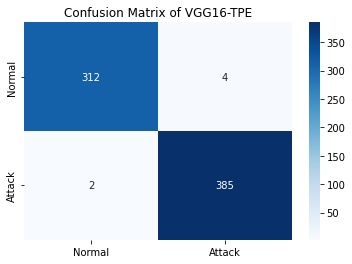

In [17]:
target_names = ['Normal', 'Attack']
conf_mat1 = confusion_matrix(y_test, prediction1)
sns.heatmap(conf_mat1, annot=True, fmt = 'd', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix of VGG16-TPE')
plt.show()

# Simulated Annealing

In [25]:
def Prediction_Model(output_unit, frozen, unit, epochs,patience, lr, dropout_rate,verbose=2, savepath='./VGG16_simulated_selected_features.h5',input_shape= input_img):
    
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    for layer in base_model.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in base_model.layers[frozen:]:
        layer.trainable = True
        
    model = Flatten()(base_model.output)
    model = Dense(units = unit,activation='relu')(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(output_unit, activation='sigmoid')(model)
    
    model = Model(base_model.input, model, name='vgg')
    
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_accuracy',  mode='auto', patience=patience, verbose=verbose)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=savepath, 
                                                          monitor='val_accuracy', 
                                                          mode='auto', 
                                                          verbose=verbose, 
                                                          save_best_only=True)
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[early_stopping,model_checkpoint],
        verbose = verbose
    )
    return history

In [26]:
#15-18
def objective(params):
    
    params = {
        'frozen': int(params['frozen']),
        'unit': int(params['unit']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    frozen=params['frozen']
    unit = params['unit']
    epochs=params['epochs']
    patience=params['patience']
    lr=params['lr']
    dropout_rate=params['dropout_rate']

    Prediction_Model(output_unit = 1, frozen=frozen, unit = unit, epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    accuracy = Prediction(vgg_model=load_model('./VGG16_simulated_selected_features.h5'))

    print('accuracy:%s'%accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [27]:
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'unit': hp.quniform('unit', 128, 512, 128),
    'epochs': hp.quniform('epochs', 10, 30, 5),
    'patience': hp.quniform('patience', 2, 10, 1),
    'lr': hp.quniform('lr', 0.001, 0.005, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.1, 0.5, 0.1),
}

optimal_parameter = fmin(fn=objective,
                         space=space,
                         algo=anneal.suggest,
                         max_evals=10)

print("Best Optimal Parameters Using Simulated Annealing {}".format(optimal_parameter))


Epoch 1/20                                            

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

<ipython-input-25-e5feeba82dbe>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                      
Epoch 1: val_accuracy improved from -inf to 0.55050, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 7s - loss: 9.7898 - accuracy: 0.6295 - val_loss: 0.6894 - val_accuracy: 0.5505 - 7s/epoch - 154ms/step

Epoch 2/20                                            

                                                      
Epoch 2: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.6597 - accuracy: 0.6809 - val_loss: 0.6926 - val_accuracy: 0.5505 - 6s/epoch - 121ms/step

Epoch 3/20                                            

                                                      
Epoch 3: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.6354 - accuracy: 0.6809 - val_loss: 0.7109 - val_accuracy: 0.5505 - 6s/epoch - 123ms/step

Epoch 4/20                                            

                                                      
Epoch 4: val_accuracy did not improve from 0.55050

47/47 - 6s 

<ipython-input-25-e5feeba82dbe>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                               
Epoch 1: val_accuracy improved from -inf to 0.55050, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 7s - loss: 2.0256 - accuracy: 0.6522 - val_loss: 0.5522 - val_accuracy: 0.5505 - 7s/epoch - 154ms/step

Epoch 2/25                                                                     

                                                                               
Epoch 2: val_accuracy improved from 0.55050 to 0.81650, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 7s - loss: 0.4311 - accuracy: 0.7223 - val_loss: 0.5147 - val_accuracy: 0.8165 - 7s/epoch - 142ms/step

Epoch 3/25                                                                     

                                                                               
Epoch 3: val_accuracy improved from 0.81650 to 0.85064, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 6s - loss: 0.2485 - accuracy: 0.9

<ipython-input-25-e5feeba82dbe>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.94168, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 8s - loss: 1.5998 - accuracy: 0.9065 - val_loss: 0.1590 - val_accuracy: 0.9417 - 8s/epoch - 160ms/step

Epoch 2/15                                                                       

                                                                                 
Epoch 2: val_accuracy did not improve from 0.94168

47/47 - 6s - loss: 0.0448 - accuracy: 0.9826 - val_loss: 0.1601 - val_accuracy: 0.9360 - 6s/epoch - 123ms/step

Epoch 3/15                                                                       

                                                                                 
Epoch 3: val_accuracy improved from 0.94168 to 0.97582, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 7s - loss: 0.0168 - accuracy: 0.9953 - val_loss: 0.1001 - val_accuracy: 0.9758 - 7s

<ipython-input-25-e5feeba82dbe>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.56757, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 7s - loss: 14.2445 - accuracy: 0.6636 - val_loss: 0.6030 - val_accuracy: 0.5676 - 7s/epoch - 149ms/step

Epoch 2/20                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.56757 to 0.83499, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 6s - loss: 0.3835 - accuracy: 0.8985 - val_loss: 0.5667 - val_accuracy: 0.8350 - 6s/epoch - 129ms/step

Epoch 3/20                                                                       

                                                                                 
Epoch 3: val_accuracy improved from 0.83499 to 0.86486, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 6s - loss: 0.2374 - ac

<ipython-input-25-e5feeba82dbe>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                  
Epoch 1: val_accuracy improved from -inf to 0.79943, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 8s - loss: 2.3563 - accuracy: 0.7437 - val_loss: 0.5393 - val_accuracy: 0.7994 - 8s/epoch - 164ms/step

Epoch 2/20                                                                        

                                                                                  
Epoch 2: val_accuracy improved from 0.79943 to 0.83784, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 6s - loss: 0.0987 - accuracy: 0.9720 - val_loss: 0.7879 - val_accuracy: 0.8378 - 6s/epoch - 136ms/step

Epoch 3/20                                                                        

                                                                                  
Epoch 3: val_accuracy improved from 0.83784 to 0.87198, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 7s - loss: 0.0658 

<ipython-input-25-e5feeba82dbe>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                  
Epoch 1: val_accuracy improved from -inf to 0.86344, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 7s - loss: 1.0848 - accuracy: 0.8892 - val_loss: 0.6229 - val_accuracy: 0.8634 - 7s/epoch - 152ms/step

Epoch 2/10                                                                        

                                                                                  
Epoch 2: val_accuracy did not improve from 0.86344

47/47 - 6s - loss: 0.0522 - accuracy: 0.9860 - val_loss: 0.4507 - val_accuracy: 0.8506 - 6s/epoch - 124ms/step

Epoch 3/10                                                                        

                                                                                  
Epoch 3: val_accuracy improved from 0.86344 to 0.88478, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 6s - loss: 0.0277 - accuracy: 0.9880 - val_loss: 0.2294 - val_accuracy: 0.8848

<ipython-input-25-e5feeba82dbe>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.80370, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 7s - loss: 1.9825 - accuracy: 0.8371 - val_loss: 0.6746 - val_accuracy: 0.8037 - 7s/epoch - 156ms/step

Epoch 2/15                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.80370 to 0.85917, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 6s - loss: 0.0601 - accuracy: 0.9826 - val_loss: 1.2876 - val_accuracy: 0.8592 - 6s/epoch - 137ms/step

Epoch 3/15                                                                       

                                                                                 
Epoch 3: val_accuracy improved from 0.85917 to 0.86344, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 6s - loss: 0.0419 - acc

<ipython-input-25-e5feeba82dbe>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.83926, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 8s - loss: 3.2896 - accuracy: 0.9025 - val_loss: 1.7693 - val_accuracy: 0.8393 - 8s/epoch - 165ms/step

Epoch 2/25                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.83926 to 0.87340, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 6s - loss: 0.0260 - accuracy: 0.9900 - val_loss: 0.7233 - val_accuracy: 0.8734 - 6s/epoch - 137ms/step

Epoch 3/25                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.87340

47/47 - 6s - loss: 0.0487 - accuracy: 0.9907 - val_loss: 3.2907 - val_accuracy: 0.8094 - 6s

<ipython-input-25-e5feeba82dbe>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.85917, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 8s - loss: 1.0661 - accuracy: 0.9206 - val_loss: 1.0549 - val_accuracy: 0.8592 - 8s/epoch - 172ms/step

Epoch 2/10                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.85917 to 0.91323, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 6s - loss: 0.0694 - accuracy: 0.9873 - val_loss: 0.2444 - val_accuracy: 0.9132 - 6s/epoch - 137ms/step

Epoch 3/10                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.91323

47/47 - 6s - loss: 0.0366 - accuracy: 0.9927 - val_loss: 1.1322 - val_accuracy: 0.8890 - 6s

<ipython-input-25-e5feeba82dbe>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.84211, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 7s - loss: 1.7536 - accuracy: 0.8545 - val_loss: 0.5629 - val_accuracy: 0.8421 - 7s/epoch - 152ms/step

Epoch 2/15                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.84211 to 0.87624, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 6s - loss: 0.0414 - accuracy: 0.9866 - val_loss: 0.2638 - val_accuracy: 0.8762 - 6s/epoch - 135ms/step

Epoch 3/15                                                                       

                                                                                 
Epoch 3: val_accuracy improved from 0.87624 to 0.87767, saving model to ./VGG16_simulated_selected_features.h5

47/47 - 6s - loss: 0.0198 - acc

In [29]:
Prediction_Model(output_unit = 1, frozen=17, unit = 256, epochs=15, patience=7, lr=0.004, dropout_rate=0.2, verbose=1)

Epoch 1/15


<ipython-input-25-e5feeba82dbe>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


47/47 [==============================] - ETA: 0s - loss: 2.9121 - accuracy: 0.8752
Epoch 1: val_accuracy improved from -inf to 0.78236, saving model to ./VGG16_simulated_selected_features.h5
47/47 [==============================] - 8s 154ms/step - loss: 2.9121 - accuracy: 0.8752 - val_loss: 1.3557 - val_accuracy: 0.7824
Epoch 2/15
47/47 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9840
Epoch 2: val_accuracy improved from 0.78236 to 0.86486, saving model to ./VGG16_simulated_selected_features.h5
47/47 [==============================] - 7s 144ms/step - loss: 0.0416 - accuracy: 0.9840 - val_loss: 0.8760 - val_accuracy: 0.8649
Epoch 3/15
47/47 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9860
Epoch 3: val_accuracy improved from 0.86486 to 0.97155, saving model to ./VGG16_simulated_selected_features.h5
47/47 [==============================] - 6s 134ms/step - loss: 0.0401 - accuracy: 0.9860 - val_loss: 0.0788 - val_accuracy: 0.9716
Epoch 

In [18]:
model2 = load_model('./VGG16_simulated_selected_features.h5')

In [19]:
prediction2 = model2.predict(images)
prediction2 = (prediction2 > 0.5).astype(int)

In [21]:
accuracy2 = accuracy_score(y_test, prediction2)
precision2 =precision_score(y_test, prediction2, average='macro')
recall2 = recall_score(y_test, prediction2, average='macro')
f12 = f1_score(y_test, prediction2, average='macro')

output2 = (
    "Evaluation Metrics of VGG16_Simulated_Annealing:\n"
    f"Testing Accuracy: {accuracy2 * 100}\n"
    f"Precision: {precision2}\n"
    f"Recall: {recall2}\n"
    f"F1-Score: {f12}"
)

print(output2)

Evaluation Metrics of VGG16_Simulated_Annealing:
Testing Accuracy: 98.71977240398293
Precision: 0.9878559944878272
Recall: 0.986340071304746
F1-Score: 0.9870463297934415


In [22]:
target_names = ['Normal', 'Attack']
print(classification_report(y_test, prediction2, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       316
      Attack       0.98      0.99      0.99       387

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



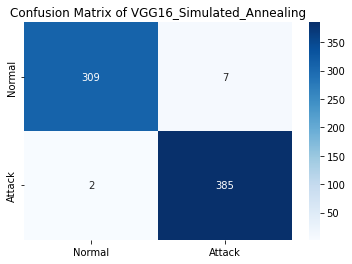

In [23]:
target_names = ['Normal', 'Attack']
conf_mat1 = confusion_matrix(y_test, prediction2)
sns.heatmap(conf_mat1, annot=True, fmt = 'd', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix of VGG16_Simulated_Annealing')
plt.show()

# Random Search

In [35]:
def Prediction_Model(output_unit, frozen, unit, epochs,patience, lr, dropout_rate,verbose=2, savepath='./VGG16_random_selected_features.h5',input_shape=input_img):
    
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    for layer in base_model.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in base_model.layers[frozen:]:
        layer.trainable = True
        
    model = Flatten()(base_model.output)
    model=Dense(units = unit, activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(output_unit, activation='sigmoid')(model)
    
    model = Model(base_model.input, model, name='vgg')
    
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_accuracy',  mode='auto', patience=patience, verbose=verbose)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=savepath, 
                                                          monitor='val_accuracy', 
                                                          mode='auto', 
                                                          verbose=verbose, 
                                                          save_best_only=True)
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[early_stopping,model_checkpoint],
        verbose = verbose
    )
    return history

In [36]:
#15-18
def objective(params):
    
    params = {
        'frozen': int(params['frozen']),
        'unit': int(params['unit']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    frozen=params['frozen']
    unit = params['unit']
    epochs=params['epochs']
    patience=params['patience']
    lr=params['lr']
    dropout_rate=params['dropout_rate']

    Prediction_Model(output_unit=1, frozen=frozen, unit = unit, epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    accuracy = Prediction(vgg_model=load_model('./VGG16_random_selected_features.h5'))

    print('accuracy:%s'%accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [37]:
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'unit': hp.quniform('unit', 128, 512, 128),
    'epochs': hp.quniform('epochs', 10, 30, 5),
    'patience': hp.quniform('patience', 2, 10, 1),
    'lr': hp.quniform('lr', 0.001, 0.005, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.1, 0.5, 0.1),
}

optimal_parameter = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Best Optimal Parameters using Random Search {}".format(optimal_parameter))


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]Epoch 1/20                                            

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

<ipython-input-35-cbbb6acf5349>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                      
Epoch 1: val_accuracy improved from -inf to 0.85491, saving model to ./VGG16_random_selected_features.h5

47/47 - 7s - loss: 1.1697 - accuracy: 0.6662 - val_loss: 0.4590 - val_accuracy: 0.8549 - 7s/epoch - 148ms/step

Epoch 2/20                                            

                                                      
Epoch 2: val_accuracy improved from 0.85491 to 0.94452, saving model to ./VGG16_random_selected_features.h5

47/47 - 6s - loss: 0.2609 - accuracy: 0.9613 - val_loss: 0.3315 - val_accuracy: 0.9445 - 6s/epoch - 127ms/step

Epoch 3/20                                            

                                                      
Epoch 3: val_accuracy improved from 0.94452 to 0.98009, saving model to ./VGG16_random_selected_features.h5

47/47 - 6s - loss: 0.1870 - accuracy: 0.9820 - val_loss: 0.2406 - val_accuracy: 0.9801 - 6s/epoch - 129ms/step

Epoch 4/20                                            

       

<ipython-input-35-cbbb6acf5349>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                
Epoch 1: val_accuracy improved from -inf to 0.75533, saving model to ./VGG16_random_selected_features.h5

47/47 - 7s - loss: 1.2548 - accuracy: 0.9166 - val_loss: 2.7584 - val_accuracy: 0.7553 - 7s/epoch - 153ms/step

Epoch 2/15                                                                      

                                                                                
Epoch 2: val_accuracy improved from 0.75533 to 0.88051, saving model to ./VGG16_random_selected_features.h5

47/47 - 6s - loss: 0.1280 - accuracy: 0.9713 - val_loss: 0.2203 - val_accuracy: 0.8805 - 6s/epoch - 130ms/step

Epoch 3/15                                                                      

                                                                                
Epoch 3: val_accuracy improved from 0.88051 to 0.91750, saving model to ./VGG16_random_selected_features.h5

47/47 - 9s - loss: 0.0190 - accuracy: 0.9933 

<ipython-input-35-cbbb6acf5349>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.55050, saving model to ./VGG16_random_selected_features.h5

47/47 - 8s - loss: 3.6498 - accuracy: 0.6228 - val_loss: 0.6883 - val_accuracy: 0.5505 - 8s/epoch - 172ms/step

Epoch 2/20                                                                       

                                                                                 
Epoch 2: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.6467 - accuracy: 0.6809 - val_loss: 0.7025 - val_accuracy: 0.5505 - 6s/epoch - 123ms/step

Epoch 3/20                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.6297 - accuracy: 0.6809 - val_loss: 0.7183 - val_accuracy: 0.5505 - 6s/epoch - 120ms/step

Epoch 4/20                                

<ipython-input-35-cbbb6acf5349>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.55050, saving model to ./VGG16_random_selected_features.h5

47/47 - 7s - loss: 17.2223 - accuracy: 0.6235 - val_loss: 0.6906 - val_accuracy: 0.5505 - 7s/epoch - 156ms/step

Epoch 2/20                                                                       

                                                                                 
Epoch 2: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.6743 - accuracy: 0.6809 - val_loss: 0.6881 - val_accuracy: 0.5505 - 6s/epoch - 123ms/step

Epoch 3/20                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.6586 - accuracy: 0.6809 - val_loss: 0.6888 - val_accuracy: 0.5505 - 6s/epoch - 124ms/step

Epoch 4/20                               

<ipython-input-35-cbbb6acf5349>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.55050, saving model to ./VGG16_random_selected_features.h5

47/47 - 7s - loss: 1.6801 - accuracy: 0.5574 - val_loss: 0.6914 - val_accuracy: 0.5505 - 7s/epoch - 151ms/step

Epoch 2/15                                                                       

                                                                                 
Epoch 2: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.6757 - accuracy: 0.6809 - val_loss: 0.6882 - val_accuracy: 0.5505 - 6s/epoch - 123ms/step

Epoch 3/15                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.6575 - accuracy: 0.6809 - val_loss: 0.6890 - val_accuracy: 0.5505 - 6s/epoch - 123ms/step

Epoch 4/15                                

<ipython-input-35-cbbb6acf5349>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.55050, saving model to ./VGG16_random_selected_features.h5

47/47 - 7s - loss: 4.9886 - accuracy: 0.6422 - val_loss: 0.6090 - val_accuracy: 0.5505 - 7s/epoch - 155ms/step

Epoch 2/20                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.55050 to 0.89047, saving model to ./VGG16_random_selected_features.h5

47/47 - 6s - loss: 0.3484 - accuracy: 0.7303 - val_loss: 0.4631 - val_accuracy: 0.8905 - 6s/epoch - 130ms/step

Epoch 3/20                                                                       

                                                                                 
Epoch 3: val_accuracy improved from 0.89047 to 0.95590, saving model to ./VGG16_random_selected_features.h5

47/47 - 6s - loss: 0.2763 - accuracy: 0.

<ipython-input-35-cbbb6acf5349>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.83073, saving model to ./VGG16_random_selected_features.h5

47/47 - 7s - loss: 1.7499 - accuracy: 0.8899 - val_loss: 1.0562 - val_accuracy: 0.8307 - 7s/epoch - 153ms/step

Epoch 2/10                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.83073 to 0.89189, saving model to ./VGG16_random_selected_features.h5

47/47 - 6s - loss: 0.0357 - accuracy: 0.9887 - val_loss: 0.5075 - val_accuracy: 0.8919 - 6s/epoch - 134ms/step

Epoch 3/10                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.89189

47/47 - 6s - loss: 0.0184 - accuracy: 0.9927 - val_loss: 0.4237 - val_accuracy: 0.8777 - 6s/epoch

<ipython-input-35-cbbb6acf5349>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.80654, saving model to ./VGG16_random_selected_features.h5

47/47 - 8s - loss: 0.8115 - accuracy: 0.8224 - val_loss: 1.1012 - val_accuracy: 0.8065 - 8s/epoch - 162ms/step

Epoch 2/20                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.80654 to 0.96444, saving model to ./VGG16_random_selected_features.h5

47/47 - 6s - loss: 0.0779 - accuracy: 0.9733 - val_loss: 0.1334 - val_accuracy: 0.9644 - 6s/epoch - 137ms/step

Epoch 3/20                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.96444

47/47 - 6s - loss: 0.0363 - accuracy: 0.9887 - val_loss: 0.1809 - val_accuracy: 0.8876 - 6s/epoch

<ipython-input-35-cbbb6acf5349>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.55050, saving model to ./VGG16_random_selected_features.h5

47/47 - 8s - loss: 18.1741 - accuracy: 0.6395 - val_loss: 0.6900 - val_accuracy: 0.5505 - 8s/epoch - 164ms/step

Epoch 2/10                                                                       

                                                                                 
Epoch 2: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.6716 - accuracy: 0.6809 - val_loss: 0.6880 - val_accuracy: 0.5505 - 6s/epoch - 119ms/step

Epoch 3/10                                                                       

                                                                                 
Epoch 3: val_accuracy did not improve from 0.55050

47/47 - 6s - loss: 0.6562 - accuracy: 0.6809 - val_loss: 0.6891 - val_accuracy: 0.5505 - 6s/epoch - 122ms/step

Epoch 4/10                               

<ipython-input-35-cbbb6acf5349>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



                                                                                 
Epoch 1: val_accuracy improved from -inf to 0.71977, saving model to ./VGG16_random_selected_features.h5

47/47 - 8s - loss: 12.2813 - accuracy: 0.6168 - val_loss: 0.5618 - val_accuracy: 0.7198 - 8s/epoch - 173ms/step

Epoch 2/10                                                                       

                                                                                 
Epoch 2: val_accuracy improved from 0.71977 to 0.83642, saving model to ./VGG16_random_selected_features.h5

47/47 - 7s - loss: 0.1744 - accuracy: 0.9419 - val_loss: 0.9243 - val_accuracy: 0.8364 - 7s/epoch - 146ms/step

Epoch 3/10                                                                       

                                                                                 
Epoch 3: val_accuracy improved from 0.83642 to 0.85917, saving model to ./VGG16_random_selected_features.h5

47/47 - 7s - loss: 0.1004 - accuracy: 0

In [38]:
Prediction_Model(output_unit = 1, frozen = 16, unit = 256, epochs = 20, patience = 8, lr = 0.001, dropout_rate = 0.2, verbose = 1)

Epoch 1/20


<ipython-input-35-cbbb6acf5349>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


47/47 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.8344
Epoch 1: val_accuracy improved from -inf to 0.85064, saving model to ./VGG16_random_selected_features.h5
47/47 [==============================] - 8s 148ms/step - loss: 0.4491 - accuracy: 0.8344 - val_loss: 0.2699 - val_accuracy: 0.8506
Epoch 2/20
47/47 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9893
Epoch 2: val_accuracy improved from 0.85064 to 0.98435, saving model to ./VGG16_random_selected_features.h5
47/47 [==============================] - 7s 142ms/step - loss: 0.0401 - accuracy: 0.9893 - val_loss: 0.0785 - val_accuracy: 0.9844
Epoch 3/20
47/47 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9873
Epoch 3: val_accuracy did not improve from 0.98435
47/47 [==============================] - 6s 124ms/step - loss: 0.0429 - accuracy: 0.9873 - val_loss: 0.4653 - val_accuracy: 0.8506
Epoch 4/20
47/47 [==============================] - ETA: 0s - loss: 0.02

In [24]:
model3 = load_model('./VGG16_random_selected_features.h5')

In [25]:
prediction3 = model3.predict(images)
prediction3 = (prediction3 > 0.5).astype(int)

In [26]:
accuracy3 = accuracy_score(y_test, prediction3)
precision3 =precision_score(y_test, prediction3, average='macro')
recall3 = recall_score(y_test, prediction3, average='macro')
f1_3 = f1_score(y_test, prediction3, average='macro')

output2 = (
    "Evaluation Metrics of VGG16_Random_Search:\n"
    f"Testing Accuracy: {accuracy3 * 100}\n"
    f"Precision: {precision3}\n"
    f"Recall: {recall3}\n"
    f"F1-Score: {f1_3}"
)

print(output2)


Evaluation Metrics of VGG16_Random_Search:
Testing Accuracy: 99.43100995732574
Precision: 0.9942514637098092
Recall: 0.9942514637098092
F1-Score: 0.9942514637098092


In [27]:
target_names = ['Normal', 'Attack']
print(classification_report(y_test, prediction3, target_names=target_names))


              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       316
      Attack       0.99      0.99      0.99       387

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



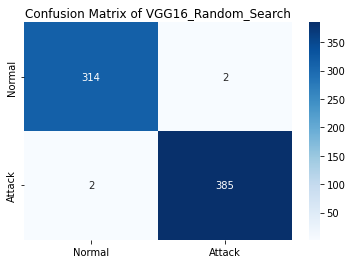

In [28]:
target_names = ['Normal', 'Attack']
conf_mat1 = confusion_matrix(y_test, prediction3)
sns.heatmap(conf_mat1, annot=True, fmt = 'd', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix of VGG16_Random_Search')
plt.show()